In [199]:
import torch
from acq import UCB, EI, PI, KG, find_next_batch, optimize_acqf
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import core.kernel as kernel
from core.cigp_baseline import cigp

## Define the objective function
This objective function represents a simple sum of sine functions. The goal is to demonstrate a basic mathematical function that exhibits periodic behavior with different frequencies. The input 'x' is the variable at which the sine functions are evaluated, and the result is the sum of sin(x) and sin(2x).

In [200]:
def objective_function(x):
    # Simple sum of sine functions for demonstration
    return torch.sin(x)+torch.sin(2*x)

## Initialize prior knowledge with 5 random points

In [201]:
input_dim = 1
num_initial_points = 20
torch.manual_seed(123)
train_x = torch.rand(num_initial_points, input_dim) * 10  # Random points in [0, 10] for each dimension
train_y = objective_function(train_x).reshape(-1,1)

# Initialize the surrogate model
This code initializes a surrogate model for Bayesian optimization. The surrogate model (CIGP_withMean) is equipped with a chosen kernel (ARDKernel) to capture the underlying patterns in the data.  The Adam optimizer is then set up to optimize the model's parameters during the training process. 

In [202]:
kernel1 = kernel.ARDKernel(1)
# kernel1 = kernel.MaternKernel(1)
# kernel1 = kernel.LinearKernel(1,-1.0,1.)
# kernel1 = kernel.SumKernel(kernel.LinearKernel(1), kernel.MaternKernel(1))
model = cigp(train_x,train_y)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the mean and variance functions for acq function
The defined mean and variance functions extract the predictive mean and variance from the trained surrogate model (model) when provided with input points (X). These functions are crucial components in the computation of acquisition functions, such as the Upper Confidence Bound (UCB), and are used to guide the selection of the next point for evaluation in the Bayesian optimization process.

In [203]:
def mean_function(X):
    model.eval()
    with torch.no_grad():
        mean, _ = model.forward(X)
        return mean

def variance_function(X):
    model.eval()
    with torch.no_grad():
        _, var = model.forward(X)
        return var

# Initialize acq function
The code snippet initializes different acquisition functions for Bayesian optimization.

In [204]:
ucb = UCB(mean_function, variance_function, kappa=5)
pi = PI(mean_function, variance_function)
ei = EI(mean_function, variance_function)
kg = KG(mean_function, variance_function, num_fantasies=10)
best_y = []
# use it to remember the key iteration
key_iterations = [2,4,6,8,9,10]
predictions = []
iteration_label = True


# Bayesian optimization loop
The key iterations allow monitoring the model's behavior and predictions at specific points during the optimization process. The overall process aims to iteratively improve the surrogate model and select points for evaluation that are expected to yield the best objective values.

In [205]:
%%capture captured_output
# Bayesian optimization loop
bounds = torch.tensor([[0, 10]] * input_dim)
for iteration in range(10):  # Run for 5 iterations

    for i in range(200):
        optimizer.zero_grad()
        loss = model.negative_log_likelihood()
        loss.backward()
        optimizer.step()
        if i%10==0:
            print('iter', i, 'nll:{:.5f}'.format(loss.item()))


    #batch_points = find_next_batch(ucb, bounds, batch_size=1, n_samples=500, f_best=train_x[np.argmax(train_y)])
    # batch_points = ei.find_next_batch(bounds, batch_size=1, n_samples=1000, f_best=train_x[np.argmax(train_y)])
    #find_next_batch(acq)
    batch_points = optimize_acqf(acq=ucb, raw_samples=50, bounds=bounds, f_best=0, num_restarts=30, options=None)
    batch_points = torch.tensor(batch_points).float()

    # Evaluate the objective function
    new_y = objective_function(batch_points.squeeze()).reshape(-1,1)

    # Update the model
    train_x = torch.cat([train_x, batch_points])
    train_y = torch.cat([train_y, new_y])
    # Store the best objective value found so far
    best_y.append(new_y.max().item())
    # Visualization

    # 在关键迭代时保存模型预测
    if (iteration + 1) in key_iterations:
        model.eval()
        fixed_dims = torch.full((1, input_dim - 1), 5.0)  # Example: set them to the midpoint (5.0)
        test_points = torch.linspace(0, 10, 100)
        test_X = torch.cat((test_points.unsqueeze(1), fixed_dims.expand(test_points.size(0), -1)), 1)
        true_y = objective_function(test_X)

        with torch.no_grad():
            pred_mean, pred_var = model.forward(test_X)
            predictions.append((pred_mean, pred_var))


In [ ]:
#By running this chunck, the output of above chunck will be shown
captured_output.show()

# plot the picture
This visualization helps to understand how well the Gaussian Process model captures the true function and how uncertainty evolves as more samples are acquired during the optimization process.

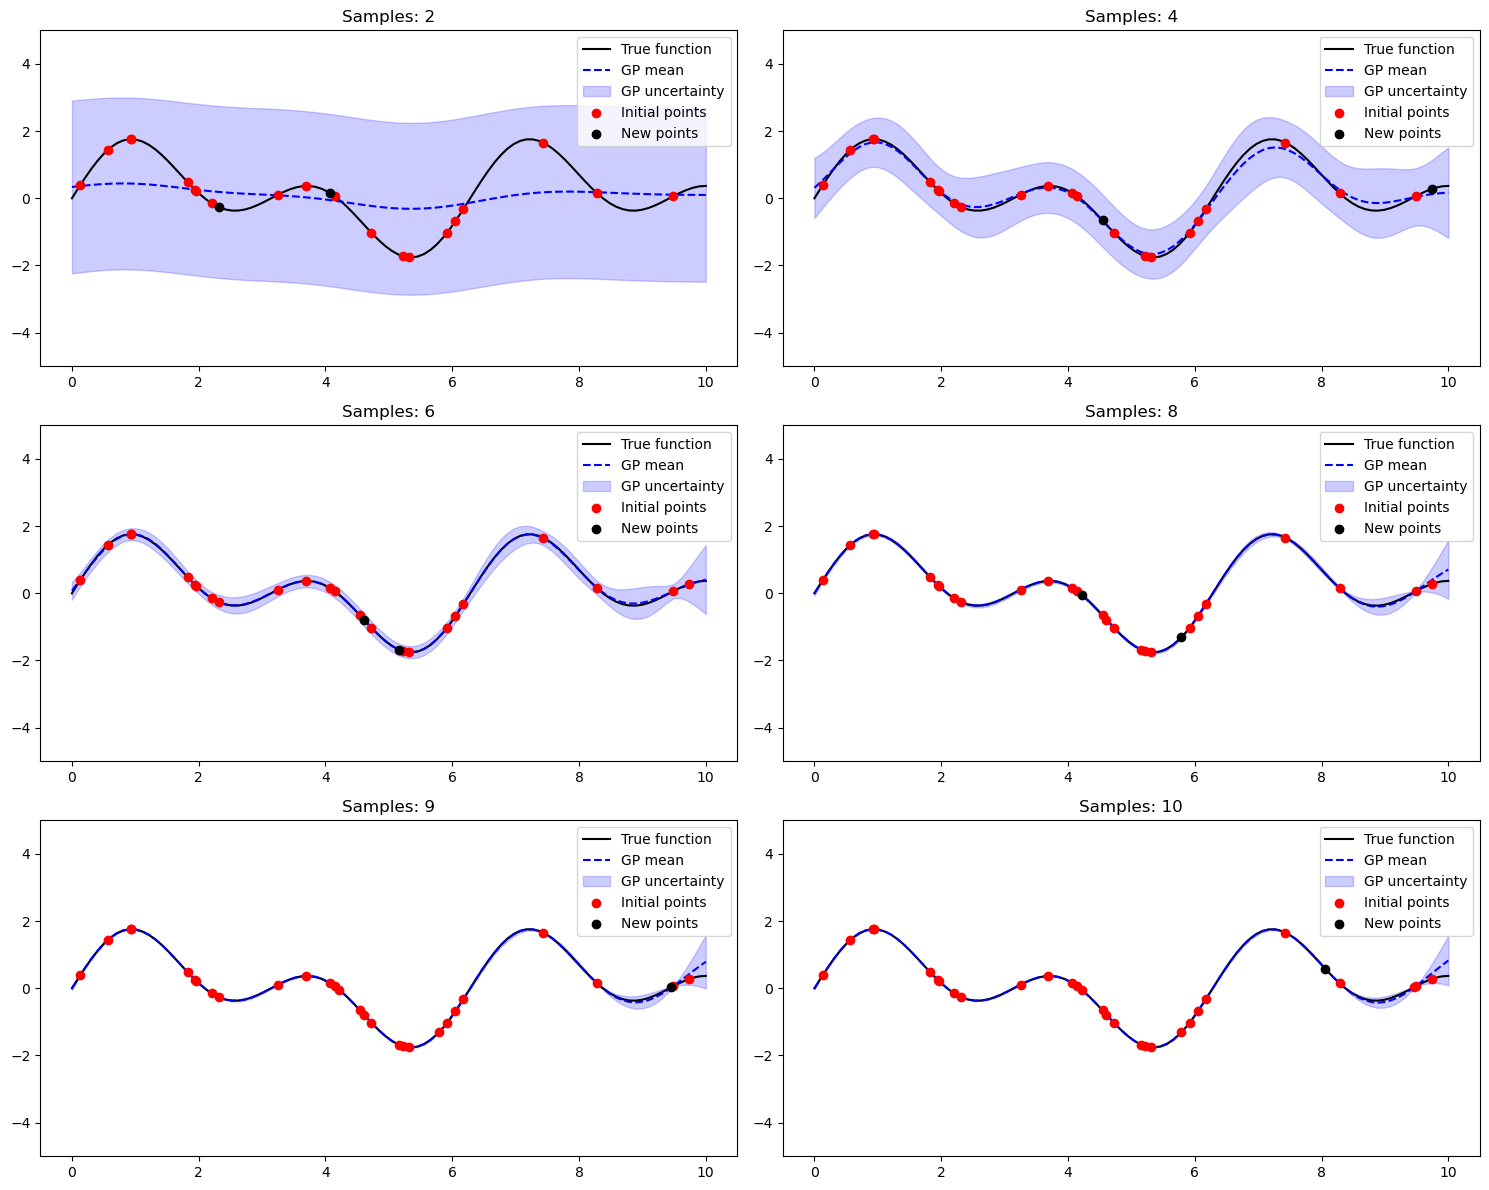

In [207]:
plt.figure(figsize=(15, 12))
for i, (pred_mean, pred_var) in enumerate(predictions):
    plt.subplot(3, 2, i+1)
    if i==0:
        num_new_points = key_iterations[i]
    else:
        num_new_points = key_iterations[i]-key_iterations[i-1]
    plt.ylim(-5, 5)
    plt.plot(test_points.numpy(), true_y.numpy(), 'k-', label='True function')
    plt.plot(test_points.numpy(), pred_mean.numpy(), 'b--', label='GP mean')
    plt.fill_between(test_points.numpy().reshape(-1),
                     (pred_mean - 1.96 * torch.sqrt(pred_var)).numpy().reshape(-1),
                     (pred_mean + 1.96 * torch.sqrt(pred_var)).numpy().reshape(-1),
                     color='blue', alpha=0.2, label='GP uncertainty')

    observed_x = train_x[:, 0].numpy()  # Only the first dimension for all observed points
    observed_y = train_y.numpy()

    # Initial observed points
    if i==0:
        plt.scatter(observed_x[:num_initial_points], observed_y[:num_initial_points], c='r', zorder=3, label='Initial points')
    else:
        plt.scatter(observed_x[:num_initial_points+key_iterations[i-1]], observed_y[:num_initial_points+key_iterations[i-1]], c='r', zorder=3, label='Initial points')
    # New points found by acquisition function
    if i==0:
        new_points_x = observed_x[num_initial_points:num_initial_points+key_iterations[i]]
        new_points_y = observed_y[num_initial_points:num_initial_points+key_iterations[i]]
    else:
        new_points_x = observed_x[num_initial_points+key_iterations[i-1]:num_initial_points+key_iterations[i]]
        new_points_y = observed_y[num_initial_points+key_iterations[i-1]:num_initial_points+key_iterations[i]]
    plt.scatter(new_points_x, new_points_y, c='black', zorder=3, label='New points')

    plt.title(f'Samples: {key_iterations[i]}')
    plt.legend()

plt.tight_layout()
plt.show()